In [16]:
# !pip install cv2
import cv2
from matplotlib import pyplot as plt

# 1. Training

 --weights for finetuning pretrained model

In [ ]:
# Navigate into training/evaluation working directory
cd /yolov7/

In [15]:
python train.py --workers 8 --device 0 --batch-size 32 --data /data/sam.yaml --img 224 224 --cfg cfg/training/yolov7-tiny-sam.yaml --weights ./yolov7-tiny.pt --name yolov7 --hyp data/hyp.scratch.p5.yaml

DATA=/data/sam.yaml

python train.py --workers 8 --device 0 --batch-size 32 --data $DATA --img 224 224 --cfg cfg/training/yolov7-tiny-sam.yaml --weights ./yolov7-tiny.pt --name yolov7 --hyp data/hyp.scratch.p5.yaml


#2. Evaluation

In [10]:
!python test.py --data /data/sam_benchmark.yaml --img 224 --batch 32 --conf 0.001 --iou 0.65 --device 0 \
	--weights runs/train/yolov75/weights/best.pt --name yolov7_224_val --save-json

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='/data/sam_benchmark.yaml', device='0', exist_ok=False, img_size=224, iou_thres=0.65, name='yolov7_224_val', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=True, save_txt=False, single_cls=False, task='val', v5_metric=False, verbose=False, weights=['runs/train/yolov75/weights/best.pt'])
YOLOR 🚀 1b13e78 torch 1.10.0a0+3fd9dcf CUDA:0 (NVIDIA GeForce RTX 3070, 7959.8125MB)

Fusing layers... 
IDetect.fuse
Model Summary: 208 layers, 6042774 parameters, 0 gradients, 13.1 GFLOPS
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

val: Scanning '/data/benchmarks/yolo_1_Aussenbahn_Tag/benchmark.cache' images an
               Class      Images      Labels           P           R      mAP@.5
                 all        2965        5523       0.807       0.651       0.707       0.377
               child        2965        2392       0.832       0.552       0.671    

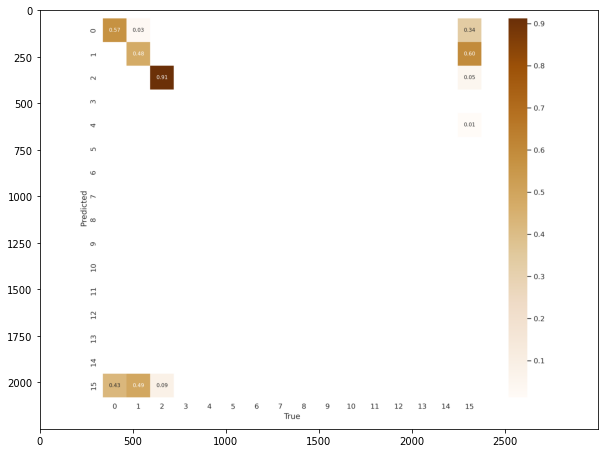

In [14]:
img = cv2.imread("/yolov7/runs/test/yolov7_224_benchmark/confusion_matrix.png")
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [136]:
import argparse
import json
import os
from pathlib import Path
from threading import Thread

import numpy as np
import torch
import yaml
from tqdm import tqdm
from models.experimental import attempt_load
from utils.loss import ComputeLoss


from utils.datasets import create_dataloader
from utils.general import coco80_to_coco91_class, check_dataset, check_file, check_img_size, check_requirements, \
    box_iou, non_max_suppression, scale_coords, xyxy2xywh, xywh2xyxy, set_logging, increment_path, colorstr
from utils.metrics import ap_per_class, ConfusionMatrix
from utils.plots import plot_images, output_to_target, plot_study_txt
from utils.torch_utils import select_device, time_synchronized, TracedModel

In [146]:
imgsz = 224
batch_size=3
dataFile = '/data/sam.yaml'
opt = argparse.Namespace()
opt.single_cls = True
task = 'val'
conf_thres = 0.3
iou_thres = 0.5

device = ('cuda:0' if torch.cuda.is_available else 'cpu')
model = attempt_load('yolov7.pt', map_location=device)  # load FP32 model
gs = max(int(model.stride.max()), 32)  # grid size (max stride)

imgsz = check_img_size(imgsz, s=gs)  # check img_size

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


In [147]:
import torchvision
with open(dataFile) as f:
    data = yaml.load(f, yaml.SafeLoader)
check_dataset(data)

dataloader = create_dataloader(data[task], imgsz, batch_size, gs, opt, pad=0.5, rect=True, prefix=colorstr(f'{task}: '))[0]

for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(dataloader, desc=False)):
        img = img.to(device, non_blocking=True)
        img = img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        targets = targets.to(device)
        nb, _, height, width = img.shape  # batch size, channels, height, width
        
        
        with torch.no_grad():
            out, train_out = model(img, augment=True)  
            
            # Run NMS
            targets[:, 2:] *= torch.Tensor([width, height, width, height]).to(device)  # to pixels
            lb = [targets[targets[:, 0] == i, 1:] for i in range(nb)] # for autolabelling
            out = non_max_suppression(out, conf_thres=conf_thres, iou_thres=iou_thres, labels=lb, multi_label=True)
        
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            path = Path(paths[si])

            if len(pred) == 0:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue


        break

val: Scanning '/data/combination_dataset/yolo_17_Combination_Dataset_data_v.1.7.0_1_3/val.cache' images and labels... 4138 found, 0 missing, 9 empty, 0 corrupted: 100%|██████████| 4138/4138 [00:00<?, ?it/s]
  0%|          | 0/1380 [00:00<?, ?it/s]


In [148]:
def output_to_target(output, scale=640):
    # Convert model output to target format [batch_id, class_id, x, y, w, h, conf]
    targets = []
    for i, o in enumerate(output):
        for *box, conf, cls in o.cpu().numpy():
            targets.append([i, cls, *list(*xyxy2xywh((np.array(box)*scale)[None])), conf])
    return np.array(targets)

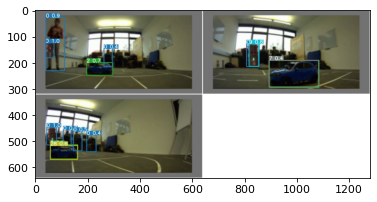

In [149]:
size = 1024
img2 = torchvision.transforms.Resize(size)(img)
plt.imshow(plot_images(img2,output_to_target(out, size/img.shape[2]), max_size=1024))

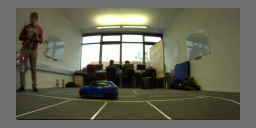

In [116]:
torchvision.transforms.ToPILImage()(img[0])